<a href="https://colab.research.google.com/github/saktiworkstation/Deteksi-Dini-Depresi-dengan-4-Model-ML/blob/main/FP_bdpal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, mean, stddev, count, when, isnan
from pyspark.ml.clustering import GaussianMixture, KMeans
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
spark = SparkSession.builder.appName("DepressionDetection").getOrCreate()

In [ ]:
df = spark.read.csv("/content/drive/MyDrive/AI Lanjut/dataset/depression_data.csv", header=True)

In [ ]:
df = spark.read.csv("/content/depression_data.csv", header=True, inferSchema=True)

In [ ]:
df.show(5)

+----------------+---+--------------+-----------------+------------------+--------------+-----------------------+-----------------+---------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+
|            Name|Age|Marital Status|  Education Level|Number of Children|Smoking Status|Physical Activity Level|Employment Status|   Income|Alcohol Consumption|Dietary Habits|Sleep Patterns|History of Mental Illness|History of Substance Abuse|Family History of Depression|Chronic Medical Conditions|
+----------------+---+--------------+-----------------+------------------+--------------+-----------------------+-----------------+---------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+
|Christine Barker| 31|       Married|Bachelor's Degree|                 2|    Non-smoker|        

#Pre-Processing

In [ ]:
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Marital Status: string (nullable = true)
 |-- Education Level: string (nullable = true)
 |-- Number of Children: integer (nullable = true)
 |-- Smoking Status: string (nullable = true)
 |-- Physical Activity Level: string (nullable = true)
 |-- Employment Status: string (nullable = true)
 |-- Income: double (nullable = true)
 |-- Alcohol Consumption: string (nullable = true)
 |-- Dietary Habits: string (nullable = true)
 |-- Sleep Patterns: string (nullable = true)
 |-- History of Mental Illness: string (nullable = true)
 |-- History of Substance Abuse: string (nullable = true)
 |-- Family History of Depression: string (nullable = true)
 |-- Chronic Medical Conditions: string (nullable = true)



In [ ]:
df.describe().show()

+-------+-----------+------------------+--------------+----------------+------------------+--------------+-----------------------+-----------------+------------------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+
|summary|       Name|               Age|Marital Status| Education Level|Number of Children|Smoking Status|Physical Activity Level|Employment Status|            Income|Alcohol Consumption|Dietary Habits|Sleep Patterns|History of Mental Illness|History of Substance Abuse|Family History of Depression|Chronic Medical Conditions|
+-------+-----------+------------------+--------------+----------------+------------------+--------------+-----------------------+-----------------+------------------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+
|  count|     41376

In [ ]:
missing_data = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
print("Missing data for each column:")
missing_data.show()

Missing data for each column:
+----+---+--------------+---------------+------------------+--------------+-----------------------+-----------------+------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+
|Name|Age|Marital Status|Education Level|Number of Children|Smoking Status|Physical Activity Level|Employment Status|Income|Alcohol Consumption|Dietary Habits|Sleep Patterns|History of Mental Illness|History of Substance Abuse|Family History of Depression|Chronic Medical Conditions|
+----+---+--------------+---------------+------------------+--------------+-----------------------+-----------------+------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+
|   0|  0|             0|              0|                 0|             0|                      0|                0| 

In [ ]:
duplicates = (
    df.groupBy(df.columns)
    .count()
    .filter("count > 1")
)

# Tampilkan duplikat
duplicates.show()

+----+---+--------------+---------------+------------------+--------------+-----------------------+-----------------+------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+-----+
|Name|Age|Marital Status|Education Level|Number of Children|Smoking Status|Physical Activity Level|Employment Status|Income|Alcohol Consumption|Dietary Habits|Sleep Patterns|History of Mental Illness|History of Substance Abuse|Family History of Depression|Chronic Medical Conditions|count|
+----+---+--------------+---------------+------------------+--------------+-----------------------+-----------------+------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+-----+
+----+---+--------------+---------------+------------------+--------------+-----------------------+-----------------+------+------

In [ ]:
numerical_columns = ['Age', 'Income', 'Number of Children']
categorical_columns = [
    "Marital Status", "Education Level", "Smoking Status", "Physical Activity Level",
    "Employment Status", "Dietary Habits", "Sleep Patterns",
    "History of Mental Illness", "History of Substance Abuse",
    "Family History of Depression", "Chronic Medical Conditions"
]

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_Index").fit(df) for col in categorical_columns]
for indexer in indexers:
    df = indexer.transform(df)

encoded_features = [f"{col}_Index" for col in categorical_columns]

In [ ]:
from pyspark.sql.types import IntegerType

for col in numerical_columns:
    df = df.withColumn(col, df[col].cast(IntegerType()))

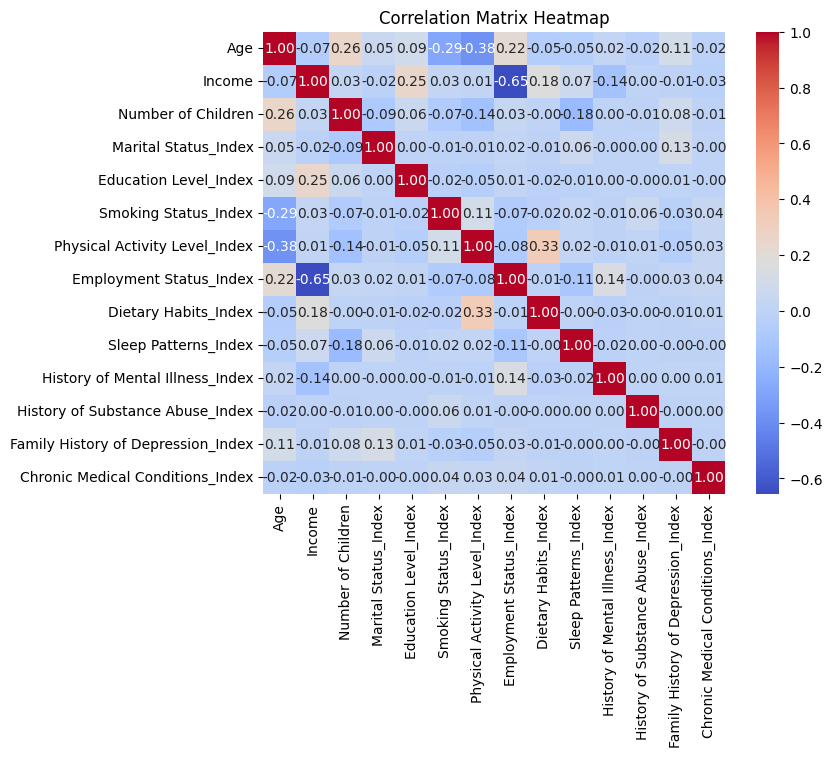

In [ ]:
encode_col = numerical_columns  + encoded_features
encode_df = df.select(encode_col)

# Mengonversi DataFrame PySpark ke Pandas untuk analisis korelasi
pandas_encode_df = encode_df.toPandas()

# Menghitung matriks korelasi
correlation_matrix = pandas_encode_df.corr()

# Visualisasi matriks korelasi menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
pandas_encode_df.to_csv('/content/encoded_data.csv', index=False)

#EDA

In [ ]:
import pandas as pd
encode_df = pd.read_csv('/content/encoded_data.csv')

In [ ]:
encode_df.head()

,Age,Income,Number of Children,Marital Status_Index,Education Level_Index,Smoking Status_Index,Physical Activity Level_Index,Employment Status_Index,Dietary Habits_Index,Sleep Patterns_Index,History of Mental Illness_Index,History of Substance Abuse_Index,Family History of Depression_Index,Chronic Medical Conditions_Index,Age Group
0,31,26265,2,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,Dewasa
1,55,42710,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,Dewasa
2,78,125332,1,2.0,3.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,Tua
3,58,9992,3,3.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,Dewasa
4,18,8595,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,Muda


In [ ]:
encode_df.columns

Index(['Age', 'Income', 'Number of Children', 'Marital Status_Index',
       'Education Level_Index', 'Smoking Status_Index',
       'Physical Activity Level_Index', 'Employment Status_Index',
       'Dietary Habits_Index', 'Sleep Patterns_Index',
       'History of Mental Illness_Index', 'History of Substance Abuse_Index',
       'Family History of Depression_Index',
       'Chronic Medical Conditions_Index'],
      dtype='object')

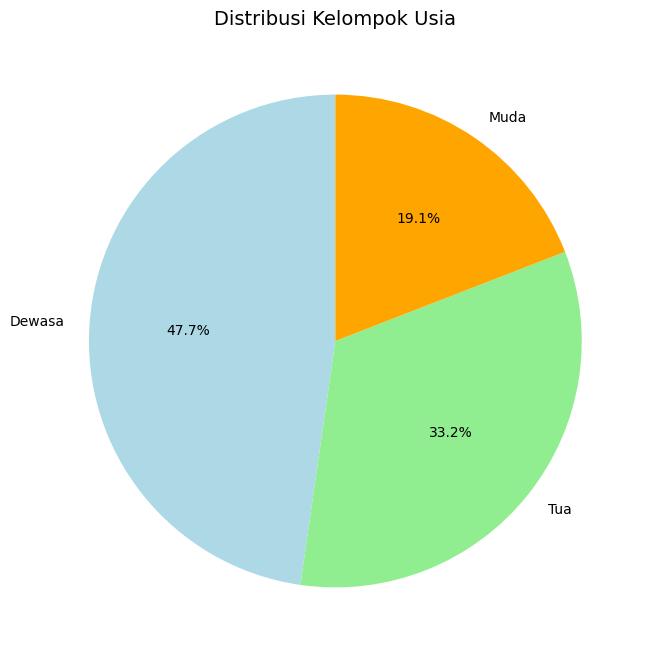

In [ ]:
def classify_age(age):
    if age < 30:
        return "Muda"
    elif 30 <= age < 60:
        return "Dewasa"
    else:
        return "Tua"

# Tambahkan kolom baru berdasarkan klasifikasi usia
encode_df['Age Group'] = encode_df['Age'].apply(classify_age)

# Hitung jumlah individu dalam setiap kelompok usia
age_group_counts = encode_df['Age Group'].value_counts()

# Pie chart untuk distribusi kelompok usia
plt.figure(figsize=(8, 8))
age_group_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'orange'])

# Tambahkan judul dan sesuaikan tampilannya
plt.title("Distribusi Kelompok Usia", fontsize=14)
plt.ylabel("")  # Hapus label default
plt.show()

<ipython-input-74-406fe69426fe>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=encode_df['History of Mental Illness_Index'], y=encode_df['Income'], palette="Blues")


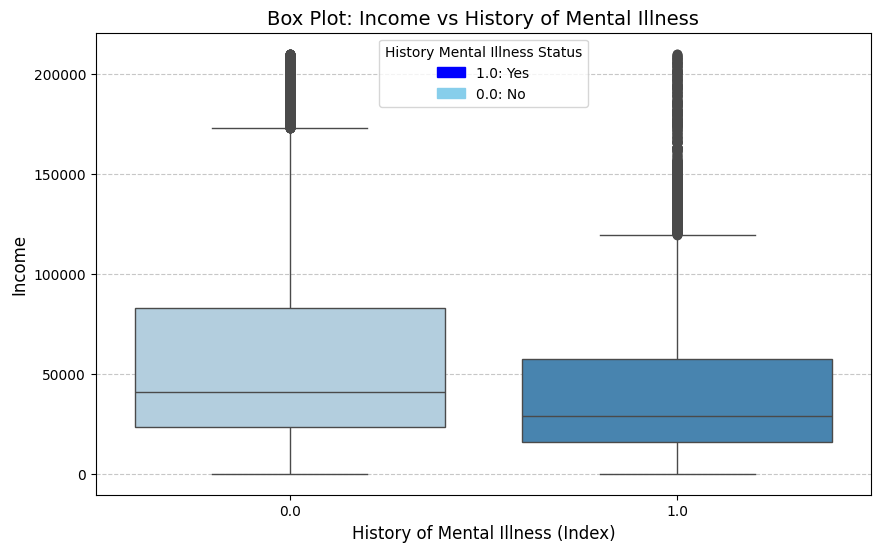

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=encode_df['History of Mental Illness_Index'], y=encode_df['Income'], palette="Blues")

# Add labels and title
plt.title("Box Plot: Income vs History of Mental Illness", fontsize=14)
plt.xlabel("History of Mental Illness (Index)", fontsize=12)
plt.ylabel("Income", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

yes_patch = mpatches.Patch(color='blue', label="1.0: Yes")
no_patch = mpatches.Patch(color='skyblue', label="0.0: No")
plt.legend(handles=[yes_patch, no_patch], title="History Mental Illness Status")
# Show the plot
plt.show()

<ipython-input-75-d822027efa3e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Employment Status_Index", y="History of Mental Illness_Index", data=encode_df, palette="viridis")


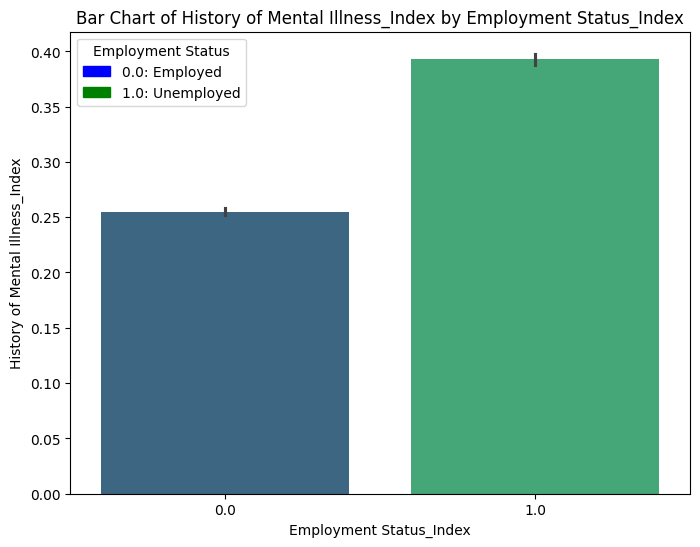

In [ ]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8, 6))
sns.barplot(x="Employment Status_Index", y="History of Mental Illness_Index", data=encode_df, palette="viridis")
plt.title("Bar Chart of History of Mental Illness_Index by Employment Status_Index")
plt.xlabel("Employment Status_Index")
plt.ylabel("History of Mental Illness_Index")
unemployed_patch = mpatches.Patch(color="green", label="1.0: Unemployed")
employed_patch = mpatches.Patch(color="blue", label="0.0: Employed")
plt.legend(handles=[employed_patch, unemployed_patch], title="Employment Status")
plt.show()

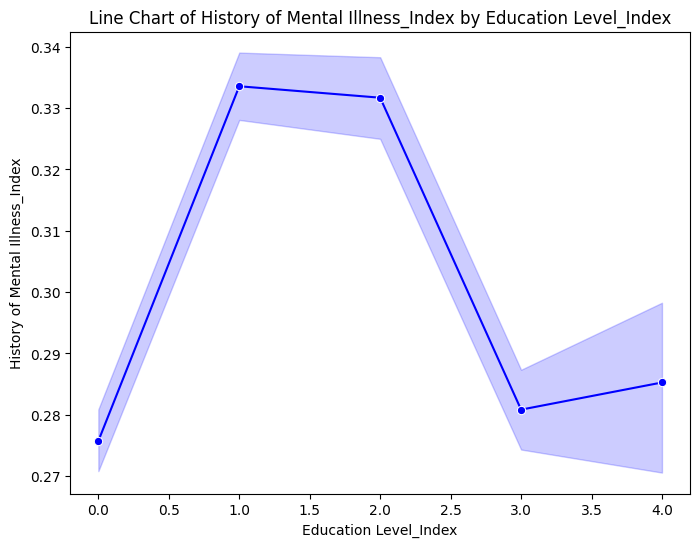

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x="Education Level_Index", y="History of Mental Illness_Index", data=encode_df, marker="o", color="blue")
plt.title("Line Chart of History of Mental Illness_Index by Education Level_Index")
plt.xlabel("Education Level_Index")
plt.ylabel("History of Mental Illness_Index")
plt.show()

In [ ]:
feature_columns = numerical_columns  + encoded_features
feature_columns

['Age',
 'Income',
 'Number of Children',
 'Marital Status_Index',
 'Education Level_Index',
 'Smoking Status_Index',
 'Physical Activity Level_Index',
 'Employment Status_Index',
 'Dietary Habits_Index',
 'Sleep Patterns_Index',
 'History of Mental Illness_Index',
 'History of Substance Abuse_Index',
 'Family History of Depression_Index',
 'Chronic Medical Conditions_Index']

In [ ]:
from pyspark.ml.stat import Correlation

vector_col = "features"
assembler = VectorAssembler(inputCols=feature_columns, outputCol=vector_col)
assembled_data = assembler.transform(df)

In [ ]:
assembled_data.select("Name", "features").show(5, truncate=False)

+----------------+----------------------------------------------------------------+
|Name            |features                                                        |
+----------------+----------------------------------------------------------------+
|Christine Barker|(14,[0,1,2,6,7,10,12,13],[31.0,26265.0,2.0,2.0,1.0,1.0,1.0,1.0])|
|Jacqueline Lewis|(14,[0,1,2,4,8,10,13],[55.0,42710.0,1.0,1.0,1.0,1.0,1.0])       |
|Shannon Church  |(14,[0,1,2,3,4,8,9,12],[78.0,125332.0,1.0,2.0,3.0,1.0,2.0,1.0]) |
|Charles Jordan  |(14,[0,1,2,3,4,6,7,9],[58.0,9992.0,3.0,3.0,3.0,1.0,1.0,1.0])    |
|Michael Rich    |(14,[0,1,3,4,7,10,12,13],[18.0,8595.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
+----------------+----------------------------------------------------------------+
only showing top 5 rows



#Cluster

<h1>K-Means</h1>

In [ ]:
kmeans = KMeans(k=3, seed=1, featuresCol="features", predictionCol="prediction_kmeans")
model_kmeans = kmeans.fit(assembled_data)

In [ ]:
predictions_kmeans = model_kmeans.transform(assembled_data)

In [ ]:
from pyspark.sql.functions import col, when

# Menambahkan kolom Stress_Level
predictions_kmeans = predictions_kmeans.withColumn(
    "Stress_Level",
    when(col("prediction_kmeans") == 0, "Low")
    .when(col("prediction_kmeans") == 1, "Moderate")
    .otherwise("High")
)


In [ ]:
predictions_kmeans.select("Name", "features", "prediction_kmeans", "Stress_Level").show()

+-------------------+--------------------+-----------------+------------+
|               Name|            features|prediction_kmeans|Stress_Level|
+-------------------+--------------------+-----------------+------------+
|   Christine Barker|(14,[0,1,2,6,7,10...|                1|    Moderate|
|   Jacqueline Lewis|(14,[0,1,2,4,8,10...|                1|    Moderate|
|     Shannon Church|(14,[0,1,2,3,4,8,...|                0|         Low|
|     Charles Jordan|(14,[0,1,2,3,4,6,...|                1|    Moderate|
|       Michael Rich|(14,[0,1,3,4,7,10...|                1|    Moderate|
|         Kathy Hill|(14,[0,1,3,4,5,6,...|                1|    Moderate|
|    Crystal Delgado|(14,[0,1,2,3,4,7,...|                1|    Moderate|
|     Charles Kaiser|(14,[0,1,3,4,6,8,...|                1|    Moderate|
|     Kathryn Taylor|(14,[0,1,3,6,8,9,...|                2|        High|
|Alexander Hernandez|(14,[0,1,2,8,9,10...|                2|        High|
|       Scott Butler|[70.0,28528.0,1.0

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Menggunakan evaluator untuk menghitung Silhouette Score
evaluator = ClusteringEvaluator(predictionCol="prediction_kmeans", featuresCol="features")
silhouette_score = evaluator.evaluate(predictions_kmeans)

print(f"Silhouette Score: {silhouette_score}")

Silhouette Score: 0.7984592747696616


<h1>Gaussion Mixture</h1>

In [ ]:
gmm = GaussianMixture(k=3, featuresCol="features", predictionCol="prediction_gmn")
model_gmn = gmm.fit(assembled_data)

In [ ]:
predictions_gmn = model_gmn.transform(assembled_data)

In [ ]:
from pyspark.sql.functions import col, when

# Menambahkan kolom Stress_Level
predictions_gmn = predictions_gmn.withColumn(
    "Stress_Level",
    when(col("prediction_gmn") == 0, "Low")
    .when(col("prediction_gmn") == 1, "Moderate")
    .otherwise("High")
)


In [ ]:
predictions_gmn.select("Name", "features", "prediction_gmn", "Stress_Level").show()

print("Gaussian Mixture Model Parameters:")
print(f"Weights: {model_gmn.weights}")
print("Cluster Centers (Means):")
model_gmn.gaussiansDF.show()

+-------------------+--------------------+--------------+------------+
|               Name|            features|prediction_gmn|Stress_Level|
+-------------------+--------------------+--------------+------------+
|   Christine Barker|(14,[0,1,2,6,7,10...|             2|        High|
|   Jacqueline Lewis|(14,[0,1,2,4,8,10...|             0|         Low|
|     Shannon Church|(14,[0,1,2,3,4,8,...|             0|         Low|
|     Charles Jordan|(14,[0,1,2,3,4,6,...|             2|        High|
|       Michael Rich|(14,[0,1,3,4,7,10...|             2|        High|
|         Kathy Hill|(14,[0,1,3,4,5,6,...|             0|         Low|
|    Crystal Delgado|(14,[0,1,2,3,4,7,...|             2|        High|
|     Charles Kaiser|(14,[0,1,3,4,6,8,...|             0|         Low|
|     Kathryn Taylor|(14,[0,1,3,6,8,9,...|             0|         Low|
|Alexander Hernandez|(14,[0,1,2,8,9,10...|             0|         Low|
|       Scott Butler|[70.0,28528.0,1.0...|             2|        High|
|     

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluator untuk menghitung Silhouette Score
evaluator = ClusteringEvaluator(predictionCol="prediction_gmn", featuresCol="features")
silhouette_score = evaluator.evaluate(predictions_gmn)

print(f"Silhouette Score: {silhouette_score}")

Silhouette Score: 0.1635423311624923


#Classification

<h1>Gradient Boost tree</h1>

In [ ]:
df.show(5, truncate=False)

+----------------+---+--------------+-----------------+------------------+--------------+-----------------------+-----------------+------+-------------------+--------------+--------------+-------------------------+--------------------------+----------------------------+--------------------------+--------------------+---------------------+--------------------+-----------------------------+-----------------------+--------------------+--------------------+-------------------------------+--------------------------------+----------------------------------+--------------------------------+
|Name            |Age|Marital Status|Education Level  |Number of Children|Smoking Status|Physical Activity Level|Employment Status|Income|Alcohol Consumption|Dietary Habits|Sleep Patterns|History of Mental Illness|History of Substance Abuse|Family History of Depression|Chronic Medical Conditions|Marital Status_Index|Education Level_Index|Smoking Status_Index|Physical Activity Level_Index|Employment Status_

In [ ]:
categorical_columns = [
    "Marital Status", "Education Level", "Smoking Status", "Physical Activity Level",
    "Employment Status", "Dietary Habits", "Sleep Patterns",
    "History of Mental Illness", "History of Substance Abuse",
    "Family History of Depression", "Chronic Medical Conditions"
]
for col_name in categorical_columns:
    df = df.fillna({col_name: "Unknown"})

In [ ]:
label_column = "History of Mental Illness_Index"
encoded_features = [f"{col}_Index" for col in categorical_columns if col != "History of Mental Illness"]
numerical_features = ["Age", "Number of Children", "Income"]

In [ ]:
assembler = VectorAssembler(inputCols=numerical_features, outputCol="raw_features")
raw_data = assembler.transform(df)

scaler = MinMaxScaler(inputCol="raw_features", outputCol="scaled_features")
scaler_model = scaler.fit(raw_data)
scaled_data = scaler_model.transform(raw_data)

In [ ]:
final_assembler = VectorAssembler(inputCols=["scaled_features"] + encoded_features, outputCol="features")
final_data = final_assembler.transform(scaled_data).select("features", label_column)

In [ ]:
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
gbt = GBTClassifier(labelCol=label_column, featuresCol="features", maxIter=50)

In [ ]:
param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxBins, [32, 64]) \
    .addGrid(gbt.maxIter, [20, 50]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol=label_column, metricName="accuracy")

crossval = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
cv_model = crossval.fit(train_data)

In [ ]:
predictions = cv_model.transform(test_data)

accuracy = evaluator.evaluate(predictions)
print(f"Test Set Accuracy: {accuracy:.4f}")

predictions.select("features", label_column, "prediction").show()

Test Set Accuracy: 0.6909
+--------------------+-------------------------------+----------+
|            features|History of Mental Illness_Index|prediction|
+--------------------+-------------------------------+----------+
|(13,[0,1,2],[0.12...|                            0.0|       0.0|
|(13,[0,1,2],[0.19...|                            0.0|       0.0|
|(13,[0,1,2],[0.20...|                            0.0|       0.0|
|(13,[0,1,2],[0.25...|                            1.0|       0.0|
|(13,[0,1,2],[0.32...|                            0.0|       0.0|
|(13,[0,1,2],[0.33...|                            0.0|       0.0|
|(13,[0,1,2],[0.37...|                            1.0|       0.0|
|(13,[0,1,2],[0.45...|                            0.0|       0.0|
|(13,[0,1,2],[0.54...|                            0.0|       0.0|
|(13,[0,1,2],[0.54...|                            0.0|       0.0|
|(13,[0,1,2],[0.54...|                            0.0|       0.0|
|(13,[0,1,2],[0.56...|                            

In [ ]:
best_model = cv_model.bestModel
print("Feature Importances:")
print(best_model.featureImportances)

Feature Importances:
(13,[0,1,2,3,4,5,6,7,8,9,10,11,12],[0.1664641654732761,0.057056991289352155,0.1649317062483497,0.06032720513166231,0.13201693929399322,0.06686294594950921,0.03945242375417893,0.15500089606442835,0.05380120786408969,0.05480918895996521,0.009701098954121034,0.021272053054691074,0.018303177962383097])


<h1>Random Forest</h1>

In [ ]:
label_column = "History of Mental Illness_Index"
encoded_features = [f"{col}_Index" for col in categorical_columns if col != "History of Mental Illness"]

In [ ]:
assembler = VectorAssembler(inputCols=encoded_features, outputCol="features")

In [ ]:
rf = RandomForestClassifier(featuresCol="features", labelCol=label_column, numTrees=100)

In [ ]:
pipeline = Pipeline(stages=[assembler, rf])

In [ ]:
train_data_rf, test_data_rf = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .addGrid(rf.numTrees, [20, 50]) \
    .build()

evaluator_rf = MulticlassClassificationEvaluator(labelCol=label_column, metricName="accuracy")

crossval_rf = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator_rf, numFolds=3)
cv_model_rf = crossval_rf.fit(train_data_rf)

In [ ]:
predictions_rf = cv_model_rf.transform(test_data_rf)

In [ ]:
accuracy = evaluator_rf.evaluate(predictions_rf)
print(f"Test Set Accuracy: {accuracy:.4f}")

predictions_rf.select("features", label_column, "prediction").show()

Test Set Accuracy: 0.6988
+--------------------+-------------------------------+----------+
|            features|History of Mental Illness_Index|prediction|
+--------------------+-------------------------------+----------+
|(10,[0,3,5,6,7],[...|                            1.0|       0.0|
|(10,[2,5,7],[2.0,...|                            0.0|       0.0|
|(10,[0,2,3,5,6],[...|                            1.0|       0.0|
|[0.0,1.0,1.0,1.0,...|                            0.0|       0.0|
|(10,[1,5,6],[2.0,...|                            0.0|       0.0|
|[1.0,1.0,1.0,2.0,...|                            0.0|       0.0|
|(10,[1,4,7,8],[1....|                            1.0|       0.0|
|(10,[2,4,9],[1.0,...|                            0.0|       0.0|
|(10,[1,6,8],[2.0,...|                            0.0|       0.0|
|[1.0,1.0,1.0,2.0,...|                            0.0|       0.0|
|(10,[1,2,6],[2.0,...|                            1.0|       0.0|
|(10,[1,2,3,7],[2....|                            

In [ ]:
best_rf_model = cv_model_rf.bestModel
# Access the RandomForestClassifier from the pipeline stages
rf_model = best_rf_model.stages[-1]
print("Feature Importances:")
print(rf_model.featureImportances)

Feature Importances:
(10,[0,1,4,5,6,7,8],[0.01855087672950778,0.003948155783209329,0.8221105278252822,0.0006987932602993289,0.15080650790510752,0.0017665519735370406,0.00211858652305695])


#Stop Session

In [ ]:
# 12. Menutup SparkSession
spark.stop()

#Kesimpulan

Untuk melakukan clutering akurasi dari K-Means sekitar 0.79 yang jauh lebih baik daripada Gaussian Mixture yang hanya sekitar 0.16. Sedangkan untuk klasifikasi hasil akurasi RandomForest sekitar 0.6988 sedikit lebih baik daripada Gradient Boost Tree yang akurasinya sekitar 0.6909. Sehingga K-means dan Random Forest emnjadi pilihan terbaik untuk melakukan clustering dan klasifikasi pada dataset ini.